[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98      1614
     Neutral       0.96      0.92      0.94      1614
    Positive       0.93      0.96      0.95      1614

    accuracy                           0.96      4842
   macro avg       0.96      0.96      0.96      4842
weighted avg       0.96      0.96      0.96      4842



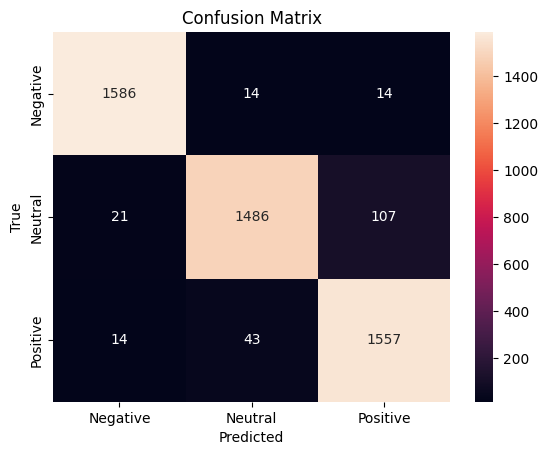

✅ Model, label encoder, and vectorizer saved.


In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
import joblib
import regex

nltk.download('stopwords')

# Negation words to keep
negation_words = {
    "not", "no", "nor", "don't", "didn't", "doesn't", "hadn't", "hasn't", "haven't",
    "isn't", "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
    "weren't", "won't", "wouldn't", "cannot", "can't", "couldn't"
}

stop_words = set(stopwords.words('english')) - negation_words

def handle_negations(text):
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"\b(not|no|never|cannot|can't|won't|don't|doesn't|didn't|isn't|wasn't|shouldn't|wouldn't|couldn't|haven't|hasn't|hadn't|mustn't|needn't|mightn't|shan't|nor)\s+(\w+)", r"\1_\2", text)
    return text

EMOJI_PATTERN = regex.compile(
    r'['
    r'\p{Emoji}'  # Unicode property for emoji (requires `regex` module)
    r'\U0001F600-\U0001F64F'  # Emoticons
    r'\U0001F300-\U0001F5FF'  # Symbols & pictographs
    r'\U0001F680-\U0001F6FF'  # Transport & map symbols
    r'\U0001F1E0-\U0001F1FF'  # Flags
    r'\U00002702-\U000027B0'  # Dingbats
    r'\U000024C2-\U0001F251'  # Enclosed characters
    r']',
    flags=regex.UNICODE
)

def clean_text(text):
    text = text.lower()
    text = handle_negations(text)
    # Extract emojis
    emojis = ''.join(EMOJI_PATTERN.findall(text))

    # Remove all non-letter, non-emoji, non-space chars
    allowed_pattern = regex.compile(r'[a-z\s]|' + EMOJI_PATTERN.pattern)
    filtered_chars = allowed_pattern.findall(text)
    filtered_text = ''.join(filtered_chars)
    filtered_text = re.sub(r'\s+', ' ', filtered_text).strip()

    # text = re.sub(r"[^a-z_\s]", "", text)
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# 1. Read both CSV files
df1 = pd.read_csv("reviews2.csv")  # Your original reviews file
df2 = pd.read_csv("emojiDataset2.csv")  # Your second reviews file

# 2. Standardize column names and select relevant columns
df1 = df1[['Reviews', 'Rating']].dropna()
df2.columns = [col.strip().capitalize() for col in df2.columns]
df2 = df2[['Reviews', 'Rating']].dropna()

# 3. Concatenate both DataFrames
df = pd.concat([df1, df2], ignore_index=True).reset_index(drop=True)

# 4. Map ratings to sentiment
def map_rating(r):
    if r in [4, 5]: return "Positive"
    elif r == 3: return "Neutral"
    else: return "Negative"

df['Sentiment'] = df['Rating'].apply(map_rating)

# 5. Clean the reviews
df['Cleaned_Reviews'] = df['Reviews'].apply(clean_text)

# 6. Encode sentiment labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Sentiment'])  # 0: Negative, 1: Neutral, 2: Positive

# 7. Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df['Cleaned_Reviews'].values.reshape(-1, 1), df['Label'])
X_res = X_res.flatten()
y_res = y_res

# 8. Split into train, val, test
X_train, X_temp, y_train, y_temp = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 9. Vectorize text
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# 10. Train model
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_vec, y_train)

# 11. Evaluate on validation set
y_pred = clf.predict(X_val_vec)
print(classification_report(y_val, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 12. Save model, encoder, and vectorizer
joblib.dump(clf, 'best_sentiment_model.pkl')
joblib.dump(le, 'label_encoder.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("✅ Model, label encoder, and vectorizer saved.")

# 13. Prediction loop
def preprocess_for_prediction(text):
    return clean_text(text)



In [6]:
clf = joblib.load('best_sentiment_model.pkl')
le = joblib.load('label_encoder.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

while True:
    review = input("\nEnter a review to classify (or type 'exit' to quit): ")
    if review.lower() == 'exit':
        break
    review_clean = preprocess_for_prediction(review)
    review_vec = vectorizer.transform([review_clean])
    prediction = clf.predict(review_vec)
    print("Predicted Sentiment:", le.inverse_transform(prediction)[0])


Enter a review to classify (or type 'exit' to quit): 👎
Predicted Sentiment: Positive

Enter a review to classify (or type 'exit' to quit): 😊
Predicted Sentiment: Positive

Enter a review to classify (or type 'exit' to quit): 👍
Predicted Sentiment: Positive

Enter a review to classify (or type 'exit' to quit): 😒
Predicted Sentiment: Positive

Enter a review to classify (or type 'exit' to quit): 😢
Predicted Sentiment: Positive

Enter a review to classify (or type 'exit' to quit): experience is worst 👎
Predicted Sentiment: Negative

Enter a review to classify (or type 'exit' to quit): nothing special 😐
Predicted Sentiment: Neutral

Enter a review to classify (or type 'exit' to quit): i like this 👍
Predicted Sentiment: Positive

Enter a review to classify (or type 'exit' to quit): i do not like this 👎
Predicted Sentiment: Negative

Enter a review to classify (or type 'exit' to quit): product is not useful for me 😒
Predicted Sentiment: Negative

Enter a review to classify (or type 'exit' t